## Bivariate Granger Causality

This notebook reproduces the bivariate Granger causality example provided in the journal paper,

McGraw, M.C. and E.A. Barnes, 2018: **Memory Matters: A Case for Granger Causality in Climate Variability Studies**. J. Climate, 31, 3289–3300, https://doi.org/10.1175/JCLI-D-17-0334.1

**Granger causality in a nutshell:**

* Granger causality is based on the predictability of temporal variables. A time series $X = \{{x_t}\}_{t=1}^{T}$ is said to be a Granger cause of $Y = \{{y_t}\}_{t=1}^{T}$, if the past values of $X$  provide information about the current state of $Y$, beyond what is already known from the past values of $Y$, alone. 

* To determine Granger causality, we compare two prediction models
    - **Unrestricted model:** A model where $Y$ is predicted using the past values of both $X$ and $Y$ 
    - **Restricted model:** A model where $Y$ is predicted using only the past values of $Y$. 

* Then a statistical test is carried out to determine whether the unrestricted model significantly improves the predictability of $Y$ compared to the restricted model.  If the predictability of $Y$ is significantly improved by the inclusion of $X$ in the model, $X$ is said to Granger cause $Y$.

Additional details of the statistical tests can be found at https://support.sas.com/rnd/app/ets/examples/granger/index.htm.

Notebook created by Savini M. Samarasinghe, Colorado State University, Fort Collins, CO as part of the Data Analysis Tools for Atmospheric Scientists (DATAS) Gateway. October 2019.

**Note:** Detailed explanations of this notebook will be added in the coming months.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 

### Generate Same Data

$$D(t) = \alpha D(t-1) + {(1 - \alpha^2)}^{1/2}\epsilon_D(t)$$ 
$$R(t) = D(t-\tau)+ \gamma \epsilon_R(t)$$ 

In [2]:
def generate_sample_data(alpha, tau, gamma, num_samples, num_drop):

    """Generates D and R time series based on the given equations.
    num_samples: number of samples in the generated time series
    num_drop: number of samples dropped from the generated series to address initialization
    
    returns D and R time series each consisting (num_samples - num_drop) many samples
    """

    assert num_drop < num_samples, 'Error: num_samples has to be greater than num_drop'
    
    # initialize the variables
    d = np.empty(num_samples)
    r = np.empty(num_samples)

    e_d = np.random.normal(0,1,num_samples) # random values drawn from a standard normal distribution  
    e_r = np.random.normal(0,1,num_samples)

    # generate data
    d[0] = e_d[0]
    for i in range(1,num_samples):
        d[i] = alpha*d[i-1] + np.sqrt((1-alpha**2))*e_d[i]

    r[:tau] = e_r[:tau]
    for i in range(tau,num_samples):
        r[i] = d[i-tau] + gamma*e_r[i]

    return [d[num_drop:],r[num_drop:]] # drop first few samples

### Bivariate Granger Causality Test

In [3]:
def bivariate_granger_causality(var_y, var_x, q, significance_level, standardize_data = True, verbose = True):
  
    """ 
    Tests whether var_x (X) Granger causes var_y (Y)
    
    Steps:
    (1) Creates restricted and unrestricted regression models. 
    (2) Checks whether X significantly improves the predictability of Y using an F test.
  
    q: number of maximum lags for each predictor
    significance_level: alpha value for statistical testing
    verbose: set to True to print intermediate results

    User has the option to standardize the data. """
    
    
    def standardize_data(data):

        """Standardizes each column of the data matrix"""

        means = data.mean(axis=0)
        stds = data.std(axis=0)

        return (data - means) / stds 

    def create_restricted_unrestricted_models():
        
        """
        Restricted model: predicts Y using the past of Y
        Unrestricted model: predicts Y using the past of Y and X
        """
        
        time_series_len = len(var_y)
        restricted_model_predictors = np.empty((time_series_len-q,q))
        unrestricted_model_predictors = np.empty((time_series_len-q,q*2))

        # lagged predictors of the restricted model
        for i in range(q):
            restricted_model_predictors[:,q-i-1] = var_y.shift(-i)[:-q]

        # lagged predictors of the unrestricted model    
        for i in range(q):
            unrestricted_model_predictors[:,q-i-1] = var_y.shift(-i)[:-q]
            unrestricted_model_predictors[:,2*q-i-1] = var_x.shift(-i)[:-q]

        predictand = var_y.shift(-q)[:-q][:,np.newaxis] # variable to be predicted

        if(standardize_data):
            restricted_model_predictors = standardize_data(restricted_model_predictors)
            unrestricted_model_predictors = standardize_data(unrestricted_model_predictors)
            predictand = standardize_data(predictand)
    
        # stack a column of ones to calculate model intercept
        restricted_model_predictors = np.hstack((np.ones((time_series_len-q,1)),restricted_model_predictors)) 
        unrestricted_model_predictors = np.hstack((np.ones((time_series_len-q,1)),unrestricted_model_predictors))

        # fit the restricted and unrestricted linear regression models using ordinary least squares approach
        reg_restricted =  sm.OLS(predictand,restricted_model_predictors).fit()
        reg_unrestricted = sm.OLS(predictand,unrestricted_model_predictors).fit()
        
        if(verbose):
            print('Testing for bivariate Granger causality.')
            print('Restricted Model:')
            print('p-value of the F-test for a joint linear hypothesis = {}'.format(reg_restricted.f_pvalue))
            print('R squared value of the model = {}'.format(reg_restricted.rsquared))
            #print(reg_restricted.summary())
            print('--------------------------------------------------------------------------------------------')
            print('Unrestricted Model:')
            print('p-value of the F-test for a joint linear hypothesis = {}'.format(reg_unrestricted.f_pvalue))
            print('R squared value of the model = {}'.format(reg_unrestricted.rsquared))
            #print(reg_unrestricted.summary())

        
        return reg_restricted, reg_unrestricted, predictand, restricted_model_predictors, unrestricted_model_predictors
        
    def evaluate_F_test_on_null_hypothesis(reg_restricted, reg_unrestricted, predictand, restricted_model_predictors, 
    unrestricted_model_predictors, significance_level):
        
        """Compares the sum of squares of residuals of the unrestricted model with the restricted model using an F test"""
        
        # residuals of the restricted and unrestricted models        
        restricted_model_residuals = predictand - reg_restricted.predict(restricted_model_predictors)[:,np.newaxis]
        unrestricted_model_residuals = predictand  - reg_unrestricted.predict(unrestricted_model_predictors)[:,np.newaxis]
        
        time_series_len = len(var_y)
        # degrees of freedom
        df_num = max_lags 
        df_den = (time_series_len - 2*max_lags - 1)
        
        F_num = (np.nansum(restricted_model_residuals**2) - np.nansum(unrestricted_model_residuals**2))/df_num
        F_den = np.nansum(unrestricted_model_residuals**2)/df_den
                
        test_stat = F_num/F_den # test statistic
        F_crit = stats.f.ppf(q=1-significance_level, dfn=df_num, dfd=df_den) # critical value
            
        if(test_stat>F_crit):
            granger_cause = 1
            if(verbose):
                print('--------------------------------------------------------------------------------------------')      
                print('F test: Test statistic = {}, Critical value = {}'.format(test_stat,F_crit))
                print('Reject null hypothesis.')
        else:
            granger_cause = 0
            if(verbose):
                print('--------------------------------------------------------------------------------------------')      
                print('F test: Test statistic = {}, Critical value = {}'.format(test_stat,F_crit))  
                print('Fail to reject null hypothesis.')  
        return granger_cause
            
    reg_restricted, reg_unrestricted, predictand, restricted_model_predictors,unrestricted_model_predictors = create_restricted_unrestricted_models()
    granger_cause = evaluate_F_test_on_null_hypothesis(reg_restricted, reg_unrestricted, predictand, 
                                                       restricted_model_predictors,unrestricted_model_predictors, 
                                                       significance_level)
           
    return granger_cause, reg_unrestricted

### Example

The null hypothesis states that the variable is not a Granger cause.

In [4]:
[D,R] = generate_sample_data(alpha = 0.7, tau = 6, gamma = 0.3, num_samples = 550, num_drop = 50)

In [5]:
max_lags = 8 # maximum number of lags
significance_level = 0.05 # alpha value for statistical testing
standardize_data = True
verbose = True # set to True to print intermediate results

### Does R cause D?

In [6]:
granger_cause_RD, reg_unrestricted_RD = bivariate_granger_causality(var_y = pd.Series(D),var_x = pd.Series(R),q = max_lags, 
                                        significance_level = significance_level, standardize_data = standardize_data, 
                                                                    verbose = verbose) # does R cause D?

Testing for bivariate Granger causality.
Restricted Model:
p-value of the F-test for a joint linear hypothesis = 6.04260374461512e-83
R squared value of the model = 0.5673199570808539
--------------------------------------------------------------------------------------------
Unrestricted Model:
p-value of the F-test for a joint linear hypothesis = 1.4427882611534828e-77
R squared value of the model = 0.5745289796512507
--------------------------------------------------------------------------------------------
F test: Test statistic = 1.02297152302157, Critical value = 1.9575664404591402
Fail to reject null hypothesis.


### Does D cause R?

In [7]:
granger_cause_DR, reg_unrestricted_DR =bivariate_granger_causality(var_y = pd.Series(R),var_x = pd.Series(D),q = max_lags, 
                                       significance_level = significance_level, standardize_data = standardize_data, 
                                                                   verbose = verbose) # does D cause R?

Testing for bivariate Granger causality.
Restricted Model:
p-value of the F-test for a joint linear hypothesis = 7.888578623681349e-71
R squared value of the model = 0.5137419632456148
--------------------------------------------------------------------------------------------
Unrestricted Model:
p-value of the F-test for a joint linear hypothesis = 3.593635336532506e-272
R squared value of the model = 0.936427495493856
--------------------------------------------------------------------------------------------
F test: Test statistic = 401.4257296882361, Critical value = 1.9575664404591402
Reject null hypothesis.


i.e., D Granger causes R

### Regression coefficients of the unrestricted model to identify significant coefficients (optional)

In [8]:
print(reg_unrestricted_DR.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     437.3
Date:                Thu, 10 Oct 2019   Prob (F-statistic):          3.59e-272
Time:                        15:33:03   Log-Likelihood:                -20.246
No. Observations:                 492   AIC:                             74.49
Df Residuals:                     475   BIC:                             145.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.041e-17      0.012      9e-16      1.0

### Monte Carlo Simulation

In [9]:
num_monte_carlo = 100 # number of simulations
num_steps = 20
alpha = np.linspace(0,0.95,num_steps) 
gamma = np.linspace(0.005,10,num_steps) 
max_lags = 8 # maximum number of lags
significance_level = 0.05 # alpha value for statistical testing
standardize_data = True
verbose = False # set to True to see the intermediate steps printed out

In [10]:
causality_map_DR = np.zeros((len(alpha),len(gamma)))
causality_map_RD = np.zeros((len(alpha),len(gamma)))

for i in range(len(alpha)):
    for j in range(len(gamma)):
        
        granger_cause_RD_overall = 0
        granger_cause_DR_overall = 0
        
        for simulation in range(num_monte_carlo):
            [D,R] = generate_sample_data(alpha = alpha[i], tau = 1, gamma = gamma[j], num_samples = 550, num_drop = 50)
            
            try:
                # does R cause D?
                granger_cause_RD, reg_unrestricted_RD = bivariate_granger_causality(var_y = pd.Series(D),
                                                    var_x = pd.Series(R),q = max_lags, 
                                                    significance_level = significance_level,
                                                    standardize_data = standardize_data, verbose = verbose) 
                if(granger_cause_RD == 1):
                    granger_cause_RD_overall += granger_cause_RD

                # does D cause R?
                granger_cause_DR, reg_unrestricted_DR =bivariate_granger_causality(var_y = pd.Series(R),
                                                    var_x = pd.Series(D),q = max_lags, 
                                                    significance_level = significance_level, 
                                                    standardize_data = standardize_data, verbose = verbose) 
                if(granger_cause_DR == 1):
                    granger_cause_DR_overall += granger_cause_DR
            except:
                print("An exception occurred at alpha {} and gamma {}".format(alpha[i],gamma[j]))
            
        causality_map_DR[i,j] = np.copy(granger_cause_DR_overall)
        causality_map_RD[i,j] = np.copy(granger_cause_RD_overall)


In [11]:
def visualize_monte_carlo_results(gamma, alpha, causality_map,num_monte_carlo):
    
    fig = plt.figure(figsize=(6,5))
    gamma_grid, alpha_grid = np.meshgrid(gamma, alpha)
    cp = plt.pcolor(gamma_grid, alpha_grid, causality_map*100/num_monte_carlo, cmap='pink_r')
    plt.xlabel('gamma')
    plt.ylabel('alpha')
    cbar = plt.colorbar(cp)
    cbar.ax.set_ylabel('%')
    plt.clim((0,100))
    plt.show()

### Does D cause R?

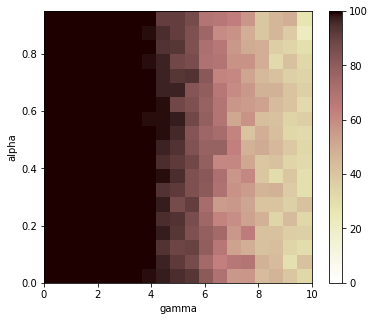

In [12]:
visualize_monte_carlo_results(gamma, alpha, causality_map_DR,num_monte_carlo)

### Does R cause D?

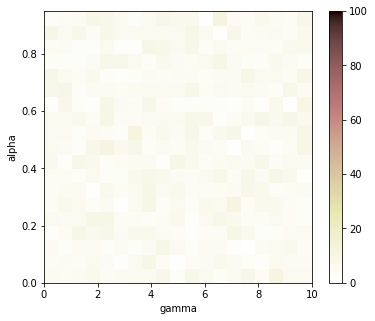

In [13]:
visualize_monte_carlo_results(gamma, alpha, causality_map_RD,num_monte_carlo)